# Face Recognition \\ (Ehab Osama)

In this Project, I will build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). In lecture, we also talked about [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). 

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 
- **Face Recognition** - "who is this person?". For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem. 

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.
    
**In this Project, I will:**
- Implement the triplet loss function
- Use a pretrained model to map face images into 128-dimensional encodings
- Use these encodings to perform face verification and face recognition

#### Load packages
Let's load the required packages. 

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:

  %reload_ext autoreload


## 0 - Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person! 
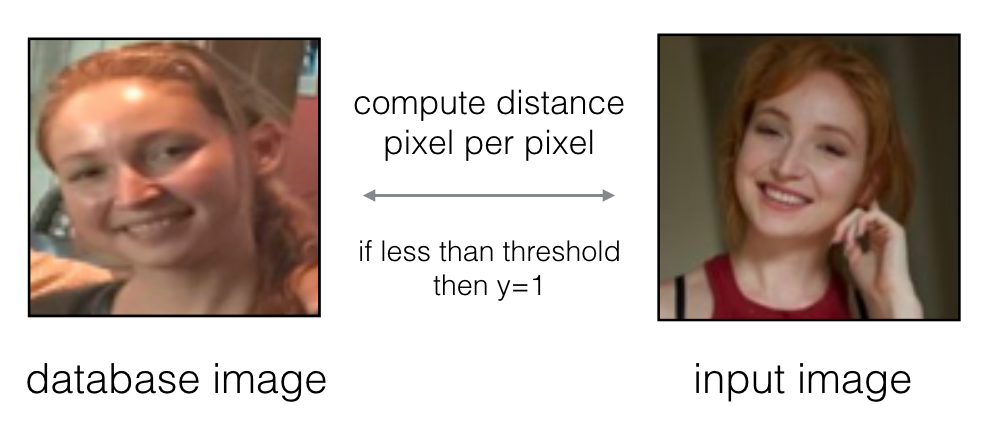


* Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on. 
  
* By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## 1 - Encoding face images into a 128-dimensional vector 

### 1.1 - Using a ConvNet  to compute encodings



* creating the model for face images

In [16]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [17]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

 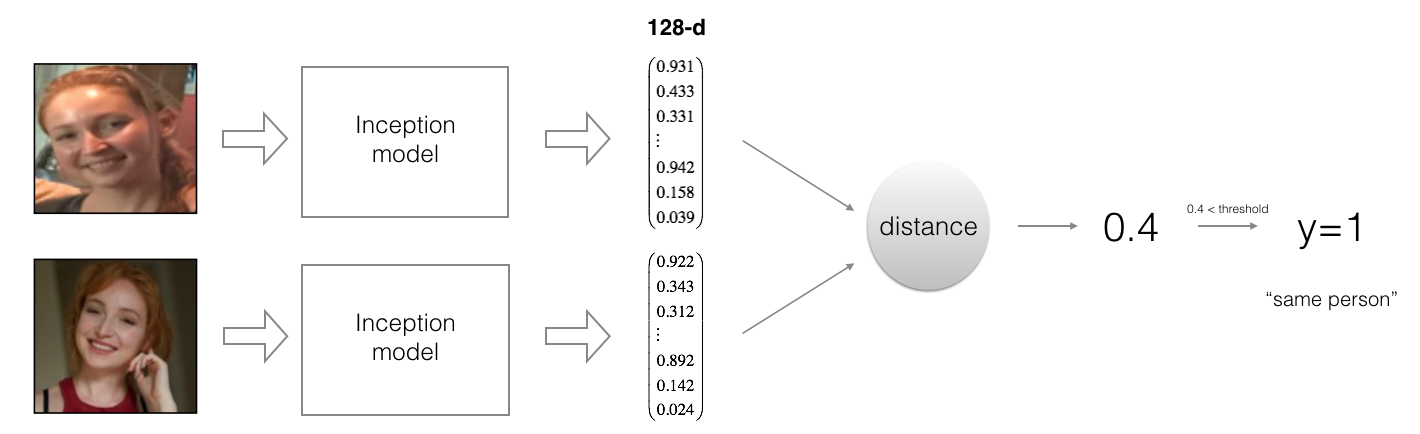
<caption><center> <u> <font color='purple'> **Figure 2**: <br> </u> <font color='purple'> By computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if:
- The encodings of two images of the same person are quite similar to each other. 
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 

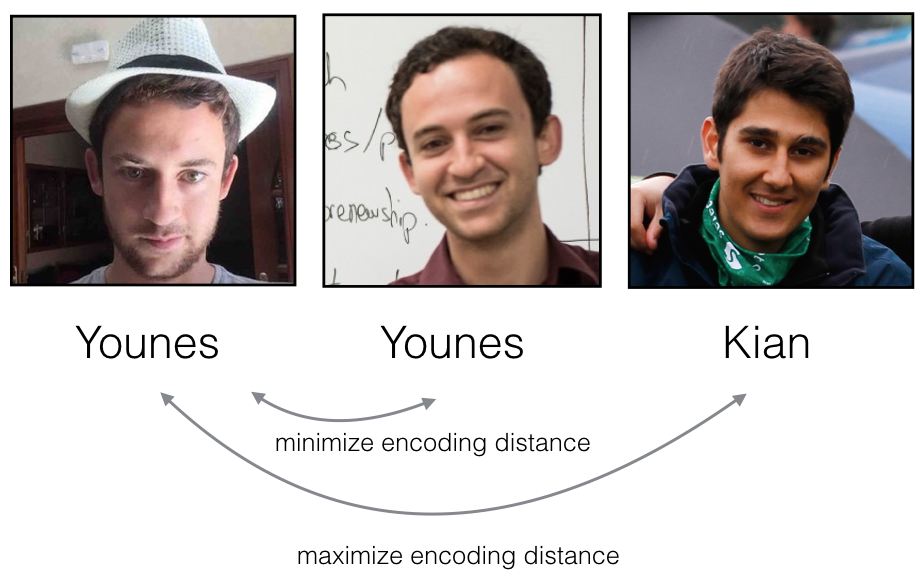
<br>
<caption><center> <u> <font color='purple'> **Figure 3**: <br> </u> <font color='purple'> In the next part, I will call the pictures from left to right: Anchor (A), Positive (P), Negative (N)  </center></caption>



### 1.2 - The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

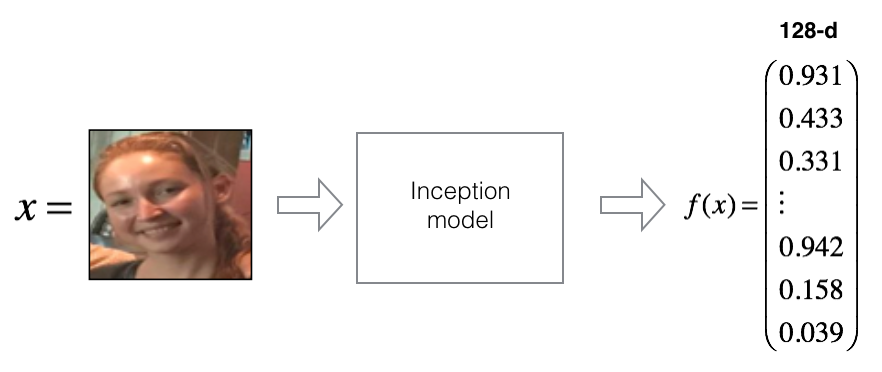

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 


In [18]:
#FUNCTION: triplet_loss

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
  
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis = -1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis = -1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist- neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
   
    
    return loss

In [22]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.143


## 2 - Loading the pre-trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, I won't train it from scratch here. Instead, I load a previously trained model.This might take a couple of minutes to run. 

In [23]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## 3 - Applying the model

I'm building a system for an office building where the building manager  would like to offer facial recognition to allow the employees to enter the building.

I'd like to build a **Face verification** system that gives access to the list of people who live or work there. To get admitted, each person has to swipe an ID card (identification card) to identify themselves at the entrance. The face recognition system then checks that they are who they claim to be.

### 3.1 - Face Verification

Let's build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image. 

The following code builds the database (represented as a python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [21]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.



In [24]:
#FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
   
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
   
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run your verification algorithm on this picture:

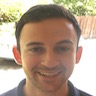


In [25]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome in!


(0.65939289, True)

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. The camera took a picture of Benoit ("images/camera_2.jpg). Let's run the verification algorithm to check if benoit can enter.

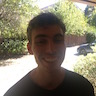


In [26]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(0.86224014, False)

### 3.2 - Face Recognition

Your face verification system is mostly working well. But since Kian got his ID card stolen, when he came back to the office the next day and couldn't get in! 

To solve this, you'd like to change your face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them! 

I'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as one of the inputs. 

In [27]:
#FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name


    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Younes is at the front-door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your who_it_is() algorithm identifies Younes. 

In [28]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.659393


(0.65939289, 'younes')

#### Conclusion
#### Ways to improve your facial recognition model
Although I won't implement it here, here are some ways to further improve the algorithm:
- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.
- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


### References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model we use is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.
- Our implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet 
